## This file has the codes for the following:
### 1. AP placement
### 2. AP topology creation
### 3. Edge server placement

In [1]:
# Requirements
import numpy as np
import pickle
import random
from random import randint, choice, uniform
import math
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib import collections as mc
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

# If reproducibility is needed
#random.seed(12345)

### 1. AP placement

APs are placed on integer coordinates in a square area. Placement is based on covering the square area with a hexagon grid to ensure full coverage.

In [2]:
def get_AP_locations_hex(area_length, coverage):
    '''
    Calculate AP locations in a grid of regular hexagon cells, where APs are placed at the centers of the hexagons.
    The locations can only be integer coordinates, which can cause small inaccuraties in the hexagon aligning.
    
    Args:
        area_length (int): The edge length of the square area in meters.
        coverage (int): The maximal radius (circumradius) of a regular hexagon in meters.
        
    Returns:
        list: The coordinates of the APs, which are in the form of (x, y) tuples.
    '''
    
    r = math.sqrt(3)/2 * coverage # minimal diameter of the regular heagon (the diameter of the inscribed circle)
    
    y_transition = round(2*r) # AP spacing in vertical direction
    ap_y_count = math.ceil(area_length / y_transition) # The number of APs in vertical direction
    
    x_transition = math.floor(1.5*coverage) # AP spacing in horizontal direction
    ap_x_count = math.ceil(area_length / x_transition) # The number of APs in horizontal direction
    
    # The first AP in horizontal direction is placed 'x_offset' meters away from the area border.
    # x_offset is half of the remaining distance after subtracting the distance 
    # between first and last AP from the area length. 
    x_offset = round( (area_length - ((ap_x_count - 1)*x_transition)) / 2)
    
    # y_offset is determined similarly to x_offset
    y_offset = round( (area_length - ((ap_y_count - 1)*y_transition)) / 2)
    
    coords = [] # List of (x,y) coordinates
    for xi in range(ap_x_count):
        x = xi * x_transition + x_offset # x coordinate for the current 'column' of hexagons
        if xi % 2 == 0: 
            # When xi (index, not the coordinate x) is even, 
            # place a total of 'ap_y_count' APs starting from 'y_offset' location.
            coords.extend([(x, yi * y_transition + y_offset) for yi in range(ap_y_count)])
        else: 
            # When xi is odd, place a total of 'ap_y_count - 1' APs starting from 'y_offset + r' location.
            # This is done because after 'ap_y_count' APs has been placed, the next column of hexagons must be shifted
            # up 'r' meters for aligning the hexagons.
            coords.extend([(x, yi * y_transition + y_offset + round(r)) for yi in range(ap_y_count-1)])
                              
    return coords

def plot_area_with_AP_cov_hex(area_length, coverage):
    '''
    Plots the AP locations and the coverage areas of the APs as hexagon cells. 
    AP locations are determined by the function 'get_AP_locations_hex'.
    
    Args:
        area_length (int): The edge length of the square area in meters.
        coverage (int): The maximal radius (circumradius) of a regular hexagon in meters.
        
    Returns:
        Nothing.
    '''
    coords = get_AP_locations_hex(area_length, coverage)
    x, y = zip(*coords)
    
    print('Area size: {} m x {} m'.format(area_length, area_length))
    print('AP coverage: {} m'.format(coverage))
    print('AP count:', len(x))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(x, y, s=1, c='k')
    for x, y in coords:
        hexagon = RegularPolygon((x, y), numVertices = 6, radius=coverage, orientation=np.radians(30),
                                 facecolor=colors[randint(0,len(colors)-1)], alpha=0.4, edgecolor='k')
        ax.add_patch(hexagon)
    ax.set_xlim(0,area_length)
    ax.set_ylim(0,area_length)
    ax.set_xlabel('Width (meters)')
    ax.set_ylabel('Length (meters)')

    plt.show()
    
def plot_area_with_AP_cov(area_length, coverage, coords):
    '''
    Plots the AP locations and the coverage areas of the APs as circles.
    
    Args:
        area_length (int): The edge length of the square area in meters.
        coverage (int): The radius of the AP coverage area in meters.
        coords (list): AP coordinates as a list of (x,y) tuples.
        
    Returns:
        Nothing.
    '''
    try:
        x, y = zip(*coords)
    except TypeError:
        print('AP locations must be given as a list of (x,y) tuples in the parameter \'coords\'')
        return
    
    print('Area size: {} m x {} m'.format(area_length, area_length))
    print('AP coverage: {} m'.format(coverage))
    print('AP count:', len(x))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(x, y, s=1, c='k')
    for i in range(len(x)):
        cir = plt.Circle((x[i], y[i]), coverage, color=colors[randint(0,len(colors)-1)], alpha=0.4)
        ax.add_patch(cir)
    ax.set_xlim(0,area_length)
    ax.set_ylim(0,area_length)
    ax.set_xlabel('Width (meters)')
    ax.set_ylabel('Length (meters)')

    plt.show()

Area size: 1000 m x 1000 m
AP coverage: 45 m
AP count: 188


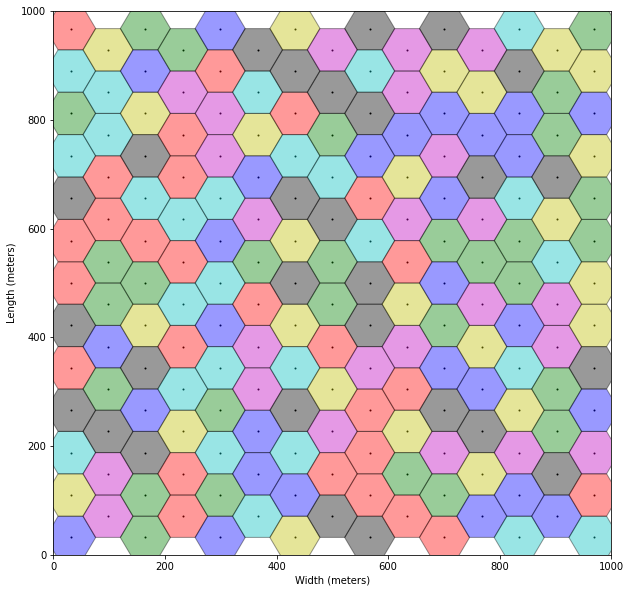

In [3]:
plot_area_with_AP_cov_hex(1000,45)

Area size: 1100 m x 1100 m
AP coverage: 45 m
AP count: 247


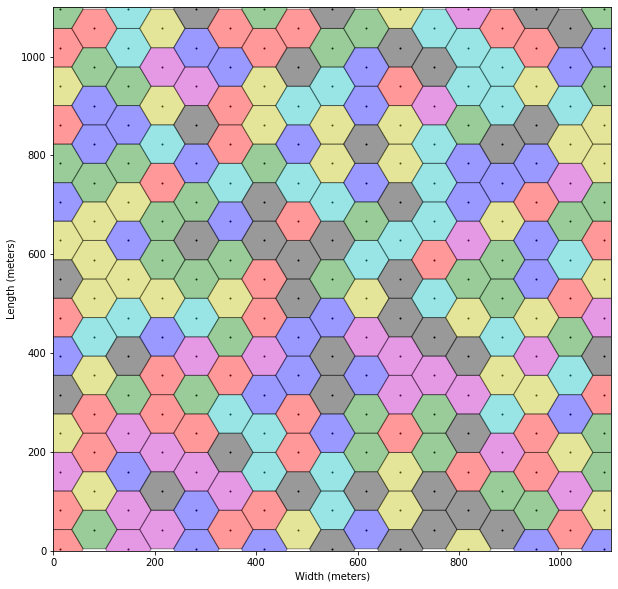

In [4]:
plot_area_with_AP_cov_hex(1100,45)

Area size: 1200 m x 1200 m
AP coverage: 45 m
AP count: 279


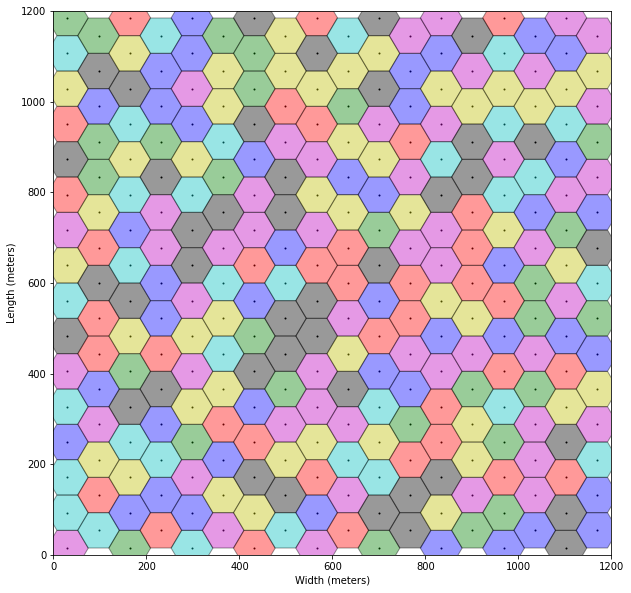

In [5]:
plot_area_with_AP_cov_hex(1200,45)

Area size: 1100 m x 1100 m
AP coverage: 45 m
AP count: 247


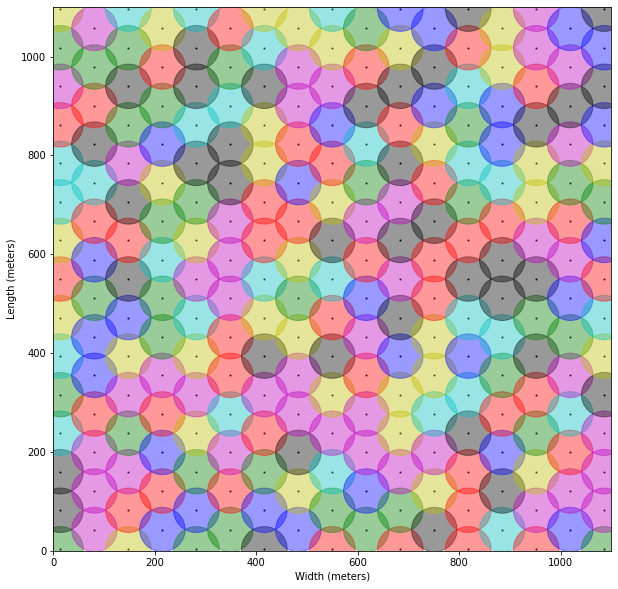

In [6]:
# The coverage near the borders depends on the size of the area and the coverage radius.
# Area length of 1100 meters and coverage of 45 meters seem to give almost perfect coverage.
coords = get_AP_locations_hex(1100,45) # Chosen coordinates for the APs
plot_area_with_AP_cov(1100,45,coords) # Plotting the APs with circular coverage areas to better check the coverage for the simulator

In [7]:
# Saving the AP coordinates
with open('AP_locations_1100m_45m.pickle', 'wb') as f:
    pickle.dump(coords, f)

### 2. AP topology creation

Creating network links between APs.

In [8]:
def euc_dist(node0,node1):
    '''
    Calculate Euclidean distance between two points.
    
    Args:
        node0 (tuple): The (x,y) coordinates of a point
        node1 (tuple): The (x,y) coordinates of another point
        
    Returns:
        float: Euclidean distance.
    '''
    return math.sqrt((node0[0] - node1[0])**2 + (node0[1] - node1[1])**2)

def get_MST_connections(locations):
    '''
    Generates a minimum spanning tree topology.
    
    Args:
        locations (list): AP locations as a list of (x,y) tuples
        
    Returns:
        list: A list of all the links between APs, one link is defined as [start_point, end_point] (a list of start and end point)
    '''
    n = len(locations)

    conn_matrix = np.zeros((n,n)) # Adjacency matrix as an upper triangular matrix
    # Starting with a fully connected topology, where the weight of each link is the euclidean distance between the nodes
    for i in range(n):
        node0 = locations[i]
        for j in range(i+1,n):
            node1 = locations[j]
            dist = euc_dist(node0, node1)
            conn_matrix[i][j] = dist
    
    X = csr_matrix(conn_matrix) # Compressed sparse row format
    Tcsr = minimum_spanning_tree(X) # Return a minimum spanning tree in the compressed sparse row format
    mst_conn = Tcsr.toarray().astype(int)
    conn_indexes = np.where(mst_conn!=0) # The indexes of all the nonzero elements in the matrix ()
    
    connections = [] # Links between APs
    for i in range(len(conn_indexes[0])):
        x = conn_indexes[0][i]
        y = conn_indexes[1][i]
        connections.append([locations[x], locations[y]])
        
    return connections

def get_random_walk_connections(locations, neigh_range):
    '''
    Generates a random spanning tree topology for the APs.
    Reference: https://stackoverflow.com/questions/2041517/random-simple-connected-graph-generation-with-given-sparseness
    
    Args:
        locations (list): AP locations as a list of (x,y) tuples
        neigh_range (float): The radius of a node's neighbourhood
        
    Returns:
        list: A list of all the links between APs, one link is defined as [start_point, end_point] (a list of start and end point)
    '''
    locations = locations[:] # Copy so that the original given list stays unchanged
    n = len(locations) 
    
    # Collect a dictionary where keys are nodes (locations) and values are lists of all the neighbours of the node
    # Neighbourhood does not include the node itself
    # Neighbours are determined based on neigh_range. All the nodes whose Euclidean distance is less than or equal to
    # neigh_range from the current node are added as its neighbours
    neighbours = {}
    for i in range(n):
        node0 = locations[i]
        neighbours[node0] = []
        for j in range(n):
            if i != j:
                node1 = locations[j]
                if euc_dist(node0,node1) <= neigh_range:
                    neighbours[node0].append(node1)
    
    # Generate the spanning tree through random walk
    locations_visited = []
    current_node = choice(locations) # Choose a random node
    locations.remove(current_node) # Remove it from the locations
    locations_visited.append(current_node) # Add it to the visited nodes
    connections = []
    
    while locations:
        neighbor_node = choice(neighbours[current_node]) # Choose a random node from the neighbourhood of the current node
        if neighbor_node not in locations_visited: # If the randomly chosen neighbour has not been visited yet,
            connections.append([current_node, neighbor_node]) # add a link between the current node and the neighbour node.
            locations.remove(neighbor_node) # Remove the nighbour from the nodes
            locations_visited.append(neighbor_node) # Add the neighbour to the visited nodes
        current_node = neighbor_node # Assing the ngihbour node as a new current node for the next round.
        
    return connections

def get_node_degrees(locations, connections):
    '''
    Calculates the node degrees.
    
    Args:
        locations (list): AP locations as a list of (x,y) tuples
        connections (list): Links between the APs, one link is defined as [start_point, end_point] (a list of start and end point)
        
    Returns:
        dict: Dictionary of node degrees, where keys are the nodes and values are the corresponding degrees.
    '''
    degrees = {node: 0 for node in locations}
    for n0, n1 in connections:
        degrees[n0] += 1
        degrees[n1] += 1
    return degrees

def get_sample_index(cum_sum):
    '''
    Samples a random value using proportional sampling technique, in which the probability of selecting a sample is 
    proportional to the weight of the sample.
    Requires an array of cumulative sums of normalized sample weights as input, and returns the index of the selected sample.
    
    Args:
        cum_sum (list): An array of cumulative sums.
    
    Returns:
        int: The index of the randomly chosen sample.
    '''
    r = uniform(0,1) # A random value between [0,1] sampled from uniform distribution.
    for i, value in enumerate(cum_sum):
        if r <= value: # if r is less than or equal to the cum_sum value at a particular index, then return that index
            return i

def get_cumulative_sum(weights):
    '''
    Normalizes an array of weights and returns an array of cumulative sums of the normalized weights. 
    
    Args:
        weights (list): An array of weights.
    
    Returns:
        list: An array of cumulative sums.
    '''
    n = len(weights)
    total_sum = sum(weights)
    normalized_weights = [weight/total_sum for weight in weights]
    cum_sum = [normalized_weights[0]]
    for i in range(1, n):
        cum_sum.append(cum_sum[i-1] +  normalized_weights[i])
    
    return cum_sum
    
def get_tunable_weight_spanning_tree(locations, kappa):
    '''
    Generates a Tunable Weight Spanning Tree topology for the APs, based on the article https://arxiv.org/pdf/1508.04447.pdf
    
    Args:
        locations (list): AP locations as a list of (x,y) tuples.
        kappa (float): A parameter that affects the weight of the spanning tree and the average path length.
    
    Returns:
        list: A list of all the links between APs, one link is defined as [start_point, end_point] (a list of start and end point)
    '''
    locations = locations[:] # Copy so that the original given list stays unchanged
    n = len(locations)
    A = [0]*n # An array for holding the random permutation of the n location nodes
    avg_node_loc = tuple([sum(tup) / n for tup in zip(*locations)]) # Average node location 
    
    # First, the nodes are ordered to obtain a random permutation of the nodes
    # At round i, a node is sampled from the remaining nodes with probability proportional 
    # to the weight of the node, which is defined as euc_dist(node, avg_node_loc)**(-kappa)
    for i in range(n):
        distance_weights = [] # The weight for each node; the probability of selecting a node is proportional to this weight
        for node in locations:
            dist = euc_dist(node, avg_node_loc)
            distance_weights.append(dist**(-kappa)) if dist != 0 else distance_weights.append(1.e-10**(-kappa))
        cum_norm_weights = get_cumulative_sum(distance_weights) # Normalize the weights and get the array of cumulative sums
        ind = get_sample_index(cum_norm_weights) # Get the index of the randomly chosen node
        A[i] = locations[ind] # Place the node to the permutation array
        locations.remove(locations[ind]) # Remove the node from the locations
                
    # Next, create the connections (links between APs)
    # At round i, the node at index i (node i) is connected to the node at some index j (node j), so that j < i 
    # and the node j is the nearest neighbour of node i
    connections = []
    for i in range(1,n):
        node0 = A[i] # the node at index i
        min_dist = np.inf
        connect_to = None # The nearest neighbour of node i
        for j in range(0,i): # Calculate the distance of node i to node j for all j < i
            node1 = A[j]
            dist = euc_dist(node0, node1)
            if dist < min_dist: # Find the nearest neighbour
                min_dist = dist
                connect_to = node1
        connections.append([node0, connect_to]) # Connect the node i to its nearest neighbour
        
    return connections
        
def add_links(locations, connections, n_of_added_links, alfa, beta, gamma):
    '''
    Adds links to the connections. The procedure for adding links is adapted from https://arxiv.org/pdf/1508.04447.pdf
    
    Procedure:
    Samples a random location (node) from 'locations' so that the probability of choosing a node is proportional to 
    its degree. Low degree node is more likely to be chosen, parameter 'alfa' affects the probability.
    After a random node i is sampled, another node j is sampled with probability proportional to the
    euclidean distance between i and j (effect controlled by parameter 'beta') and the degree of the node j
    (effect controlled by parameter 'gamma'). The link between nodes i and j is added to the connections if it
    does not already exist. No self-loops are allowed.
    
    Args:
        locations (list): AP locations as a list of (x,y) tuples.
        connections (list): A list of all the current links between APs, one link is defined as [start_point, end_point].
                            The current topology must be a connected graph.
        n_of_added_links (int): The number of links to add into the connections.
        alfa (float): A parameter that affects the probability of choosing low degree nodes as the first random location.
        beta (float): A parameter that controls the effect of distance in choosing the second random location.
        gamma (float): A parameter that controls the effect of node degree in choosing the second random location.
    
    Returns:
        Nothing.
    '''
    link_count = len(connections) + n_of_added_links
    degrees = get_node_degrees(locations, connections)
    
    # Create the weights that affect the probability for a node to be chosen. The propability is proportional to the degree
    # of the node. The bigger the parameter alfa, the more likely a low degree node is chosen.
    degree_weights = [d**(-alfa) for d in degrees.values()] 
    cum_sum_i = get_cumulative_sum(degree_weights) # Normalize the weights and get the array of cumulative sums
    
    while len(connections) < link_count:
        i = get_sample_index(cum_sum_i) # Sample an index of a location based on the degree weights
        nodei = locations[i] # Node i
        locations_no_i = locations[:] # Copy of locations
        locations_no_i.remove(nodei) # Remove node i from locations copy (self-loops not allowed)
        
        # Create the weights for choosing another node (node j). The propability is proportional to the node j's 
        # distance to node i, as well as the degree of node j. There is a trade-off between parameters beta and gamma:
        # If beta is large compared to gamma, then new links are more likely to connect nearby nodes, resulting in large
        # average path length. If gamma is large compared to beta, then new links are more likely to connect nodes to high
        # degree nodes regardless of their distance, resulting in very high degree nodes and long links.
        distance_degree_weights = [(euc_dist(nodei, n)**(-beta))*(degrees[n]**(gamma)) for n in locations_no_i]
        cum_sum_j = get_cumulative_sum(distance_degree_weights) # Normalize the weights and get the array of cumulative sums
        j = get_sample_index(cum_sum_j) # Sample an index of another location based on the distance-degree weights
        nodej = locations[j] # Node j
        
        # Finally, add the link between nodes i and j if it does not already exist
        if [nodei, nodej] not in connections and [nodej, nodei] not in connections:
            connections.append([nodei, nodej])
        
def plot_APs_and_connections(ap_coords, connections, area_length):
    '''
    Plots AP locations and connections on a square area.
    
    Args:
        ap_coords (list): AP locations as a list of (x,y) tuples.
        connections (list): A list of all the links between APs, 
                            one link is defined as [start_point, end_point] (a list of start and end point)
        area_length (int): The edge length of the square area in meters.
    
    Returns:
        Nothing.
    '''
    x, y = zip(*ap_coords)
    
    print('Area size: {} m x {} m'.format(area_length, area_length))
    print('AP count:', len(x))

    fig, ax = plt.subplots(figsize=(10, 10))
    lc = mc.LineCollection(connections, linewidths=1)
    ax.add_collection(lc)
    ax.scatter(x, y, s=10, c='k', zorder=2)
    ax.set_xlim(0,area_length)
    ax.set_ylim(0,area_length)
    ax.set_xlabel('Width (meters)')
    ax.set_ylabel('Length (meters)')

    plt.show()

Area size: 1100 m x 1100 m
AP count: 247


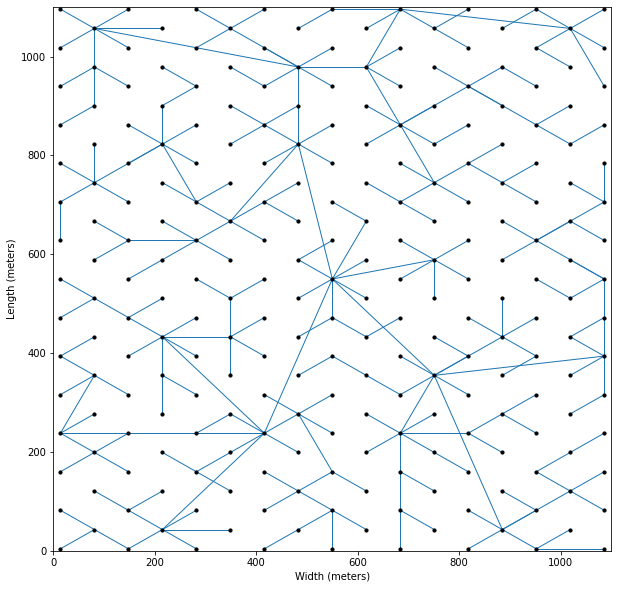

In [9]:
# Creating network links based on the Tunable Weight Spanning Tree, as it provides the best results 
# in terms of small-world and scale-free requirements, at least when compared to random walk and MST approaches.
kappa = 0.5
connections = get_tunable_weight_spanning_tree(coords, kappa)
plot_APs_and_connections(coords, connections, 1100)

In [10]:
# More links could be added, e.g., to add 5 links
#links_to_add = 5
#alfa = 0.5
#beta = 0.5
#gamma = 5
#add_links(coords, connections, links_to_add, alfa, beta, gamma)
#plot_APs_and_connections(coords, connections, 1100)

In [11]:
# Save the connections
with open('AP_links_1100m_45m.pickle', 'wb') as f:
    pickle.dump(connections, f)

### 3. Edge server placement

Placing the edge servers on the created topology. The servers are placed randomly so that the probability of choosing a node to host an edge server is proportional to the degree of the node.

In [12]:
def get_server_locations(locations, connections, server_count, theta):
    '''
    Co-locates the edge serves randomly with APs so that the probability of choosing a node is proportional to the 
    degree of the node. The effect is controlled by the parameter 'theta'.
    
    Args:
        locations (list): AP locations as a list of (x,y) tuples.
        connections (list): A list of all the links between APs, one link is defined as [start_point, end_point].
        server_count (int): The number of servers to place.
        theta (float): A parameter that affects the probability of choosing high degree nodes as server locations.
    
    Returns:
        list: Edge server locations as a list of (x,y) tuples.
    '''
    degrees = get_node_degrees(locations, connections)
    locations = locations[:] # Working with a copy of locations rather than doing changes on the list that was passed as reference
    
    # Create the weights that affect the probability for a node to be chosen. The propability is proportional to the degree
    # of the node. The bigger the parameter theta, the more likely a high degree node is chosen.
    degree_weights = [d**(theta) for d in degrees.values()] 
    
    server_locations = []
    while len(server_locations) < server_count:
        cum_sum = get_cumulative_sum(degree_weights) # Normalize the weights and get the array of cumulative sums
        i = get_sample_index(cum_sum) # Sample an index of a location based on the degree weights
        server_locations.append(locations[i]) # Add the chosen location to edge server locations
        del degree_weights[i]
        del locations[i]
        
    return server_locations
    
def plot_servers(ap_locs, server_locs, connections, area_length):
    '''
    Plots the servers, APs and connections in a square area.
    
    Args:
        ap_locs (list): AP locations as a list of (x,y) tuples.
        server_locs (list): Edge server locations as a list of (x,y) tuples.
        connections (list): A list of all the links between APs, one link is defined as [start_point, end_point].
        area_length (int): The edge length of the square area in meters.
    
    Returns:
        Nothing.
    '''
    x_ap, y_ap = zip(*ap_locs)
    x_s, y_s = zip(*server_locs)
    
    print('AP count:', len(x_ap))
    print('Edge server count:', len(x_s))

    fig, ax = plt.subplots(figsize=(10, 10))
    lc = mc.LineCollection(connections, linewidths=1)
    ax.add_collection(lc)
    ax.scatter(x_ap, y_ap, s=10, c='k', label='AP', zorder=2)
    ax.scatter(x_s, y_s, s=30, c='r', label='Edge Server + AP', zorder=2)
    ax.legend(loc='upper left',  bbox_to_anchor=(1, 1))
    ax.set_xlim(0,area_length)
    ax.set_ylim(0,area_length)
    ax.set_xlabel('Width (meters)')
    ax.set_ylabel('Length (meters)')

    plt.show()

AP count: 247
Edge server count: 20


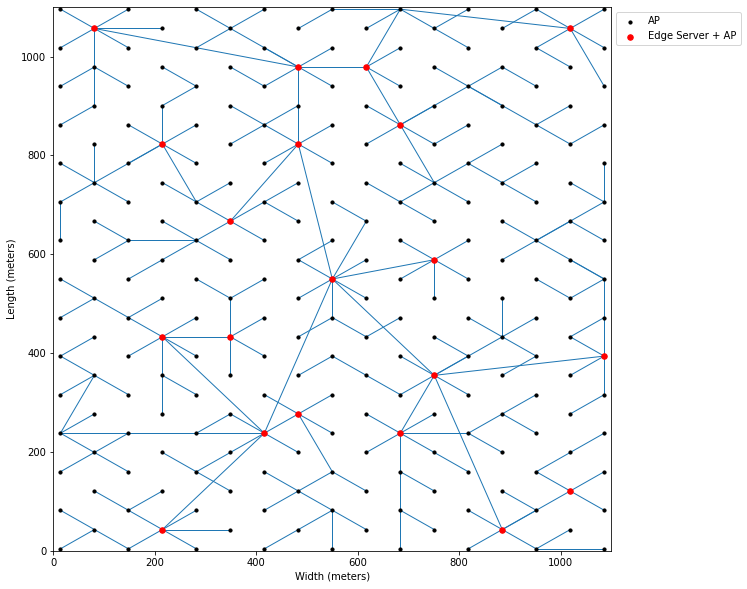

AP count: 247
Edge server count: 100


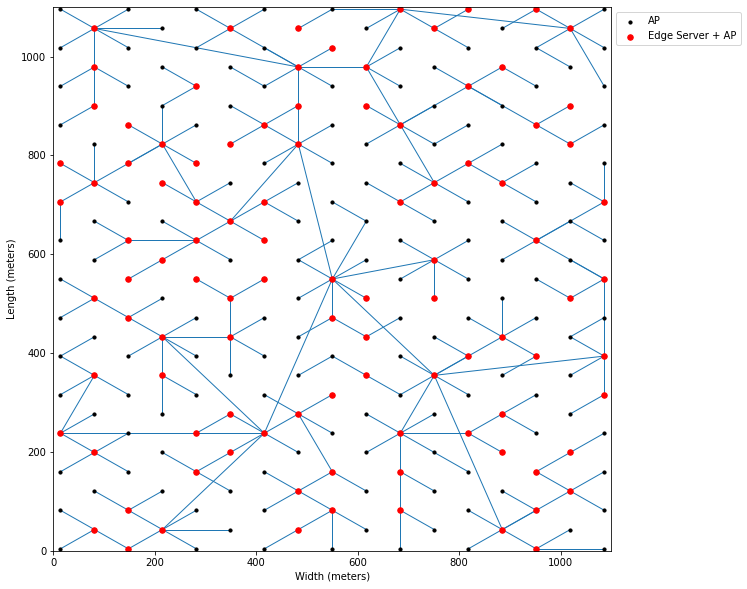

In [13]:
s_coords_20 = get_server_locations(coords, connections, 20, 5)
s_coords_100 = get_server_locations(coords, connections, 100, 3)

plot_servers(coords, s_coords_20, connections, 1100)
plot_servers(coords, s_coords_100, connections, 1100)

In [14]:
# Save the server locations
with open('Server_locations_20_1100m_45m.pickle', 'wb') as f:
    pickle.dump(s_coords_20, f)
    
with open('Server_locations_100_1100m_45m.pickle', 'wb') as f:
    pickle.dump(s_coords_100, f)